In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 1, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5', 
      'lines.markerstyle': None}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

/Applications/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Ideas
1. PCA?
2. Are they the same distributions? How to measure similarity of distributions? Bootstrap! Kullback–Leibler
3. Naive Bayes
4. Random Forest/Extremely Random Trees
5. GP
6. tf-idf -- does not make a difference for tree-based methods
7. Split out consistent local cv set. 
8. Ensemble selection
9. linear models
10. Look into other ways to transform data

In [226]:
train_df = pd.read_csv('training_data.txt', sep='|')
test_df = pd.read_csv('testing_data.txt', sep='|')
train_df.head()

,thi,mr.,ar,bill,thei,speaker,would,'s,gentleman,chairman,...,award,weapon,white,enhanc,infrastructur,overal,termin,guarante,board,Label
0,4,5,1,0,0,4,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1
1,0,2,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,8,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [238]:
sums = test_df.sum(axis=0)
sums.sort()
sums.tail(20)

support       698
american      700
peopl         717
wa            792
yield         857
time          934
gentleman     940
tax           965
act           972
's            976
would        1031
ha           1119
us           1230
research     1353
bill         1414
speaker      1448
thei         1529
ar           2442
mr.          2448
thi          3444
dtype: int64

<Container object of 1000 artists>

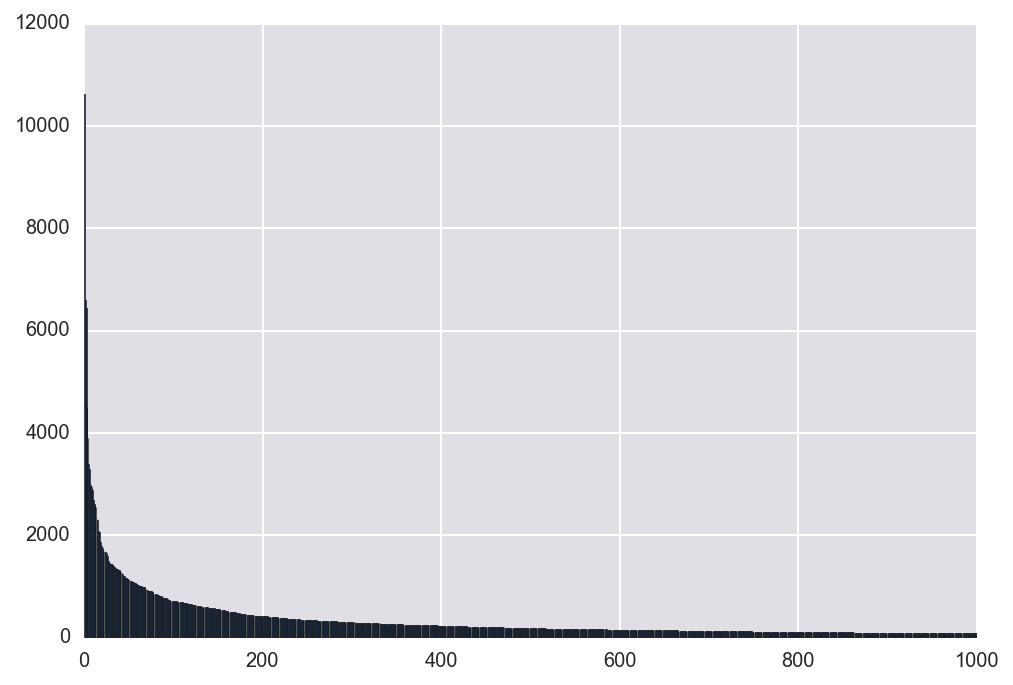

In [194]:
xcols = train_df.columns[0:-1]
sums = train_df[xcols].sum(axis=0)
plt.bar(range(len(sums)), sums)

<Container object of 1000 artists>

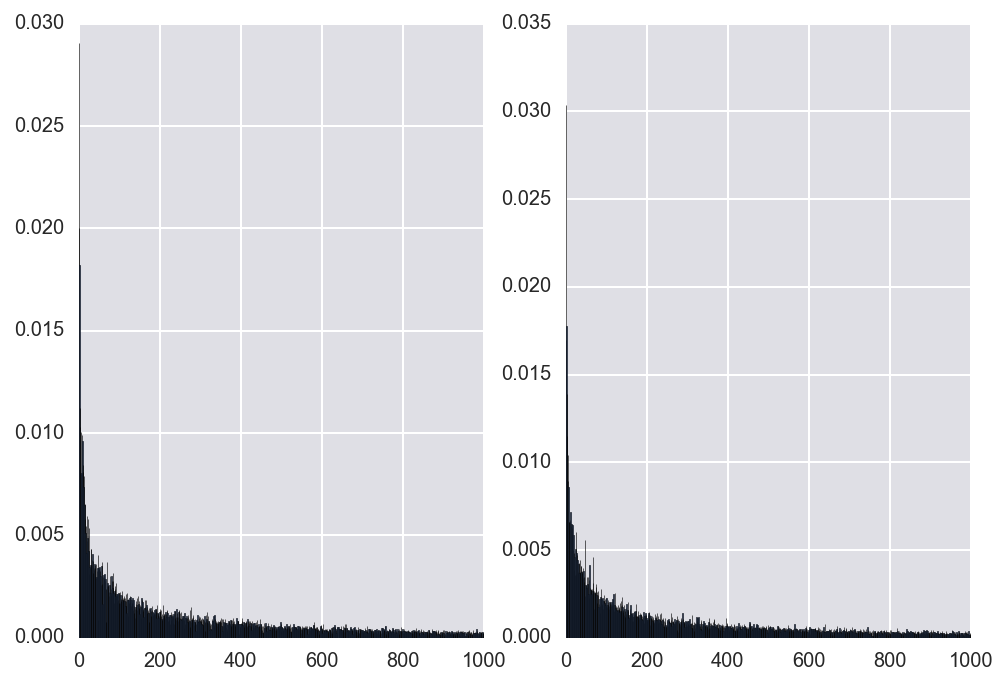

In [195]:
pos_sums = train_df[train_df['Label']==1][xcols].sum(axis=0)
neg_sums = train_df[train_df['Label']==0][xcols].sum(axis=0)
fig, ax = plt.subplots(1,2)
ax[0].bar(range(len(pos_sums)), pos_sums/sum(pos_sums))
ax[1].bar(range(len(neg_sums)), neg_sums/sum(neg_sums))

In [107]:
def tf_idf(counts):
    ell = len(counts)
    non_zero = len(np.nonzero(counts))
    return [c * np.log(ell/non_zero) for c in counts]

In [196]:
X = train_df[xcols]
Y = train_df['Label']
X_test = test_df[xcols]
X_tf_idf = pd.DataFrame(index=X.index, columns=X.columns)
X_tf_idf_test = pd.DataFrame(index=X_test.index, columns=X_test.columns)

for c in X.columns:
    X_tf_idf[c] = tf_idf(X[c])
    X_tf_idf_test[c] = tf_idf(X_test[c])
X_tf_idf.head()    

,thi,mr.,ar,bill,thei,speaker,would,'s,gentleman,chairman,...,anyon,award,weapon,white,enhanc,infrastructur,overal,termin,guarante,board
0,33.360869,41.701087,8.340217,0.000000,0.000000,33.360869,0.000000,0,16.680435,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,16.680435,0.000000,0.000000,0.000000,8.340217,0.000000,0,8.340217,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,8.340217,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,8.340217,...,0,0,0,0,0,0,0,0,0,0
3,25.020652,0.000000,0.000000,0.000000,66.721739,0.000000,16.680435,0,8.340217,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,8.340217,0.000000,8.340217,0.000000,8.340217,0.000000,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [255]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn import cross_validation
def compare(X1, X2, Y, classifier, args={}):
    scores = []
    for X in (X1, X2):
        X_train, X_cv, Y_train, Y_cv = \
        cross_validation.train_test_split(X, Y, test_size=0.1, 
                                          random_state=1)
        clf = classifier(**args)
        clf.fit(X_train, Y_train)
        scores += [clf.score(X_cv, Y_cv)]
    return scores
    
args = {'n_estimators':300,
        'min_samples_split':2,
        'min_samples_leaf':1,
       'bootstrap':True}

compare(X, X_tf_idf, Y, SVC, args={'kernel':'linear'})

[0.67780429594272074, 0.6587112171837709]

In [251]:
clf = ExtraTreesClassifier(**args)
clf.fit(X_tf_idf, Y)
predictions = clf.predict(X_tf_idf_test)

In [252]:
predictions = [1 if p==1 else 0 for p in predictions]
with open ('2016-01-23_et.txt', 'w') as f:
    f.write('Id,Prediction\n')
    for i, p in enumerate(predictions):
        f.write(str(i+1) + ',' + str(p) + '\n')